In [1]:
import os
import json
import numpy as np
import cv2

# Constants
IMG_HEIGHT = 64
IMG_WIDTH = 64
NUM_FRAMES = 32  # Fixed number of frames per segment

In [2]:
def extract_fixed_frame_segments(video_path, annotations, img_height, img_width):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    video_name = os.path.relpath(video_path, 'dataset/UCF_Crime')  # Match the JSON path format
    
    labeled_segments = []

    # Process each annotated segment
    for segment in annotations.get(video_name, []):
        start_frame = int(segment['start'] * fps)
        end_frame = int(segment['end'] * fps)
        num_segment_frames = end_frame - start_frame
        
        # Initialize frame list for this segment
        frames = []
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        
        # Extract frames from the segment
        for _ in range(num_segment_frames):
            ret, frame = cap.read()
            if not ret:
                break

            # Resize and normalize frame
            frame_resized = cv2.resize(frame, (img_width, img_height))
            frame_resized = frame_resized / 255.0  # Normalize to [0, 1]
            frames.append(frame_resized)

        # Ensure we have exactly NUM_FRAMES frames
        try:
            if len(frames) > NUM_FRAMES:
                step = len(frames) // NUM_FRAMES
                frames = frames[::step][:NUM_FRAMES]
            elif len(frames) < NUM_FRAMES:
                frames.extend([frames[-1]] * (NUM_FRAMES - len(frames)))  # Pad with last frame if fewer than NUM_FRAMES
            
            # Append processed segment with label (1 for anomalous, assumed here)
            labeled_segments.append((np.array(frames), 1))
        
        except IndexError:
            print(f"Insufficient frames for segment in video: {video_name}. Skipping this segment.")
            continue

    cap.release()
    return labeled_segments

def process_and_save_segments(json_path, video_base_path, output_dir):
    # Load annotations
    with open(json_path, 'r') as file:
        annotations_data = json.load(file)

    # Filter out irrelevant videos
    annotations = {k: v for k, v in annotations_data.items() if not k.startswith("Testing_Normal_Videos_Anomaly")}

    os.makedirs(output_dir, exist_ok=True)

    # Process each video
    for video_key, segments in annotations.items():
        video_path = os.path.join(video_base_path, video_key)
        
        if not os.path.exists(video_path):
            print(f"Video {video_path} not found, skipping.")
            continue

        # Extract segments
        labeled_segments = extract_fixed_frame_segments(video_path, annotations, IMG_HEIGHT, IMG_WIDTH)
        
        # Save each segment
        for idx, (frames, label) in enumerate(labeled_segments):
            segment_filename = f"{video_key.replace('/', '_')}_segment_{idx}.npy"
            segment_path = os.path.join(output_dir, segment_filename)
            # Save as dictionary with 'frames' and 'label'
            data_to_save = {'frames': frames, 'label': label}
            np.save(segment_path, data_to_save)
            print(f"Saved segment: {segment_path} with label {label}")

video_base_path = 'dataset/UCF_Crime'

# Run the function for test JSON and video path
test_json_path = 'dataset/annotations/test.json'
output_base_dir_test = 'dataset/extracted_segments/test'

# Run the function for train JSON and video path
train_json_path = 'dataset/annotations/train.json'
output_base_dir_train = 'dataset/extracted_segments/train'

process_and_save_segments(train_json_path, video_base_path, output_base_dir_train)
process_and_save_segments(test_json_path, video_base_path, output_base_dir_test)



Saved segment: dataset/extracted_segments/train/Abuse_Abuse001_x264.mp4_segment_0.npy with label 1
Saved segment: dataset/extracted_segments/train/Abuse_Abuse001_x264.mp4_segment_1.npy with label 1
Saved segment: dataset/extracted_segments/train/Abuse_Abuse001_x264.mp4_segment_2.npy with label 1
Saved segment: dataset/extracted_segments/train/Abuse_Abuse001_x264.mp4_segment_3.npy with label 1
Saved segment: dataset/extracted_segments/train/Abuse_Abuse002_x264.mp4_segment_0.npy with label 1
Saved segment: dataset/extracted_segments/train/Abuse_Abuse003_x264.mp4_segment_0.npy with label 1
Saved segment: dataset/extracted_segments/train/Abuse_Abuse003_x264.mp4_segment_1.npy with label 1
Saved segment: dataset/extracted_segments/train/Abuse_Abuse003_x264.mp4_segment_2.npy with label 1
Saved segment: dataset/extracted_segments/train/Abuse_Abuse003_x264.mp4_segment_3.npy with label 1
Saved segment: dataset/extracted_segments/train/Abuse_Abuse004_x264.mp4_segment_0.npy with label 1
Saved segm

In [3]:
from glob import glob

def extract_fixed_frame_segments(video_path, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    labeled_segments = []
    
    frame_files = sorted(glob(os.path.join(video_path, "*.png")))  # List all PNG files in the folder

    # Ensure we get exactly NUM_FRAMES frames
    if len(frame_files) > NUM_FRAMES:
        step = len(frame_files) // NUM_FRAMES
        frame_files = frame_files[::step][:NUM_FRAMES]
    elif len(frame_files) < NUM_FRAMES:
        frame_files.extend([frame_files[-1]] * (NUM_FRAMES - len(frame_files)))  # Pad with last frame

    frames = []
    for frame_file in frame_files:
        frame = cv2.imread(frame_file)
        frame_resized = cv2.resize(frame, (img_width, img_height)) / 255.0  # Normalize
        frames.append(frame_resized)

    # Save the frames as normal video with label 0
    labeled_segments.append((np.array(frames), 0))

    return labeled_segments


def process_and_save_segments(video_base_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # Process each normal video folder
    video_folders = sorted(glob(os.path.join(video_base_path, "*")))  # E.g., NormalVideos/video_1

    for video_folder in video_folders:
        video_name = os.path.basename(video_folder)
        print(f"Processing video folder: {video_folder}")

        # Extract fixed frames for normal videos
        labeled_segments = extract_fixed_frame_segments(video_folder, img_height=IMG_HEIGHT, img_width=IMG_WIDTH)

        # Save each normal video segment
        for idx, (frames, label) in enumerate(labeled_segments):
            segment_filename = f"{video_name}_segment_{idx}.npy"
            segment_path = os.path.join(output_dir, segment_filename)
            # Save as dictionary with 'frames' and 'label'
            data_to_save = {'frames': frames, 'label': label}
            np.save(segment_path, data_to_save)
            print(f"Saved segment: {segment_path} with label {label}")

# Paths to normal video directories and output locations
train_video_path = 'dataset/UCF_Crime_Organized/train/NormalVideos'  # Replace with actual path
test_video_path = 'dataset/UCF_Crime_Organized/test/NormalVideos'  # Replace with actual path
output_base_dir = 'dataset/extracted_segments'  # Directory to save extracted frames

# Process normal videos for training and testing
# process_and_save_segments(train_video_path, os.path.join(output_base_dir, 'trainN', 'NormalVideos'))
process_and_save_segments(test_video_path, os.path.join(output_base_dir, 'testN', 'NormalVideos'))


Processing video folder: dataset/UCF_Crime_Organized/test/NormalVideos/video_10
Saved segment: dataset/extracted_segments/testN/NormalVideos/video_10_segment_0.npy with label 0
Processing video folder: dataset/UCF_Crime_Organized/test/NormalVideos/video_100
Saved segment: dataset/extracted_segments/testN/NormalVideos/video_100_segment_0.npy with label 0
Processing video folder: dataset/UCF_Crime_Organized/test/NormalVideos/video_129
Saved segment: dataset/extracted_segments/testN/NormalVideos/video_129_segment_0.npy with label 0
Processing video folder: dataset/UCF_Crime_Organized/test/NormalVideos/video_14
Saved segment: dataset/extracted_segments/testN/NormalVideos/video_14_segment_0.npy with label 0
Processing video folder: dataset/UCF_Crime_Organized/test/NormalVideos/video_15
Saved segment: dataset/extracted_segments/testN/NormalVideos/video_15_segment_0.npy with label 0
Processing video folder: dataset/UCF_Crime_Organized/test/NormalVideos/video_150
Saved segment: dataset/extract

In [4]:
import matplotlib.pyplot as plt

def display_frames_from_npy(npy_file_path):
    """
    Loads the frames from a .npy file and displays each frame along with its label.
    
    Args:
    - npy_file_path: Path to the .npy file containing the frames and their label.
    """
    # Load the frames and labels from the .npy file
    labeled_data = np.load(npy_file_path, allow_pickle=True).item()  # .item() to get dictionary
    
    # Extract frames and label
    frames = labeled_data['frames']
    label = labeled_data['label']
    
    # Check if frames is a numpy array of expected shape
    if isinstance(frames, np.ndarray) and frames.ndim == 4:
        # Display each frame with its label
        for idx, frame in enumerate(frames):
            plt.imshow(frame)
            plt.title(f"Frame {idx + 1} - Label: {label}")
            plt.axis('off')  # Hide axes for better visualization
            plt.show()
    else:
        print("Error: Frames should be a 4D numpy array.")


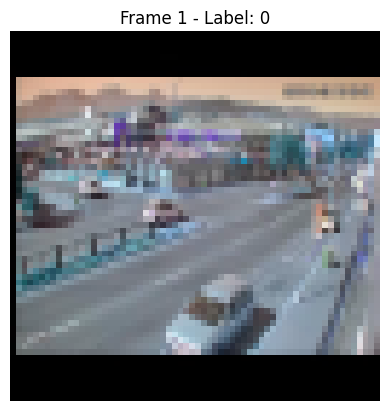

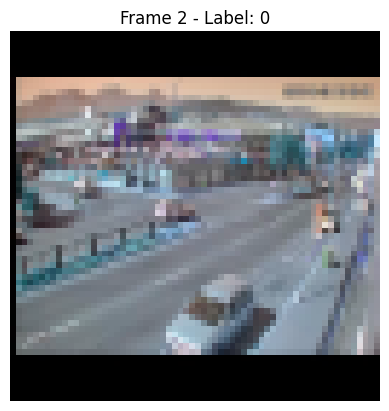

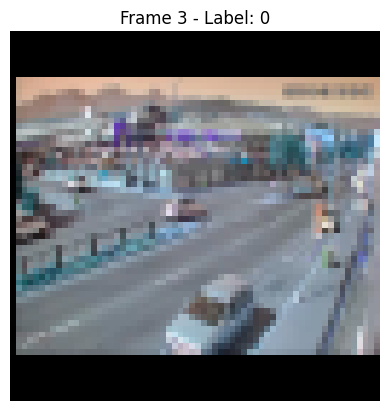

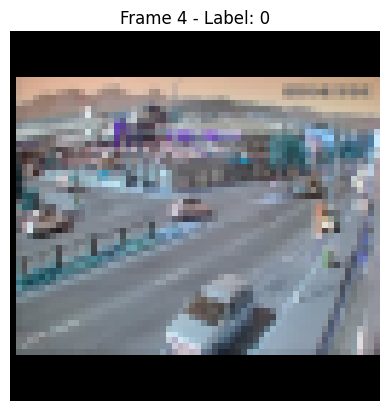

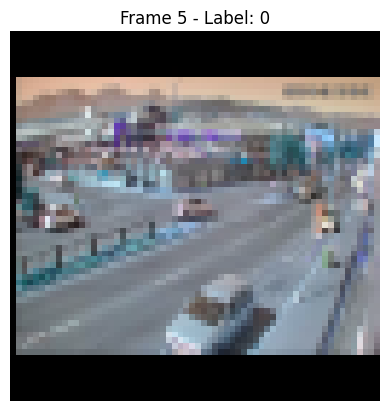

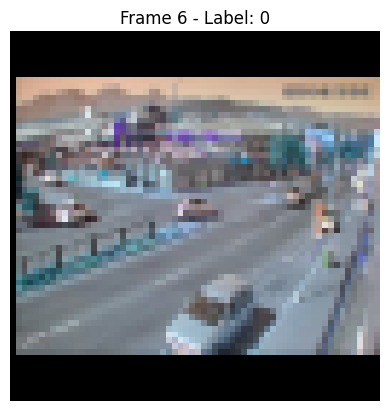

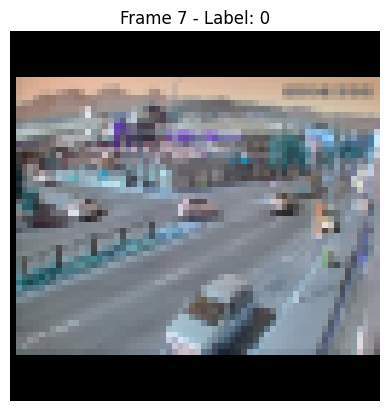

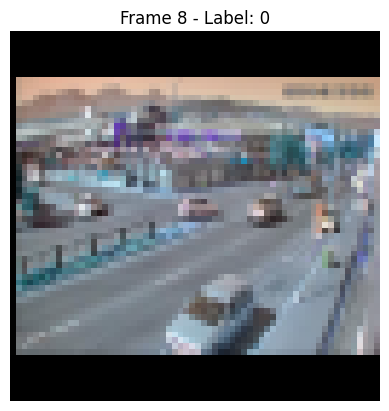

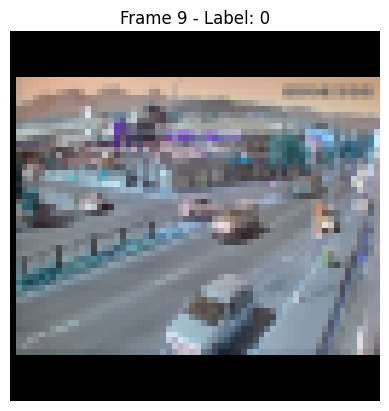

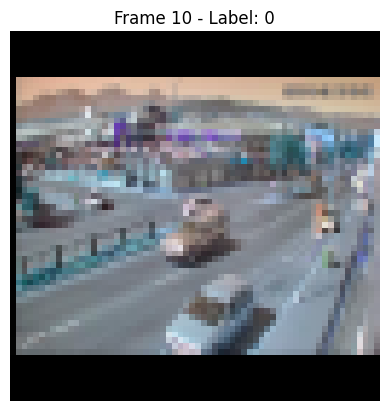

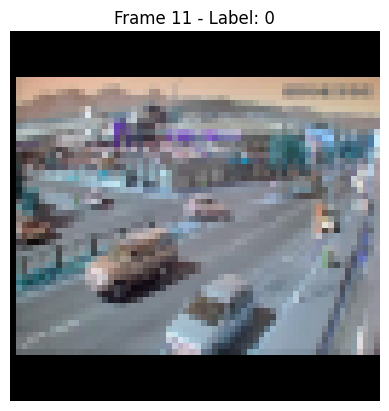

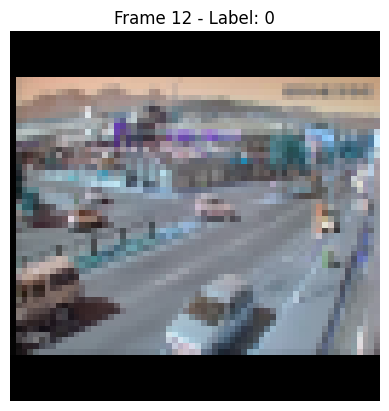

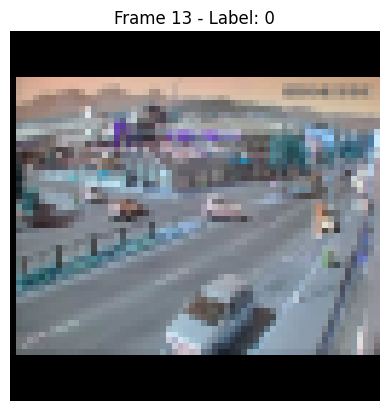

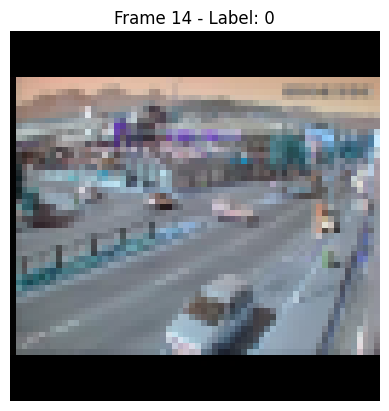

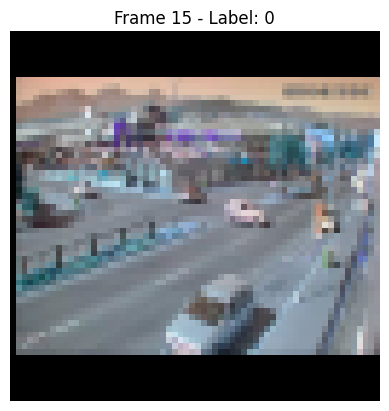

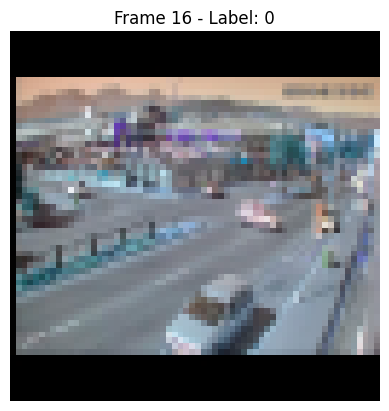

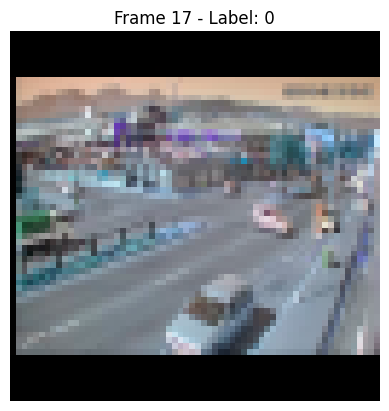

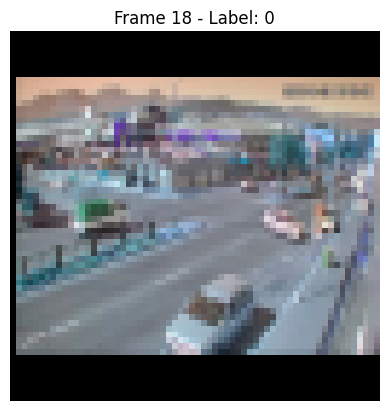

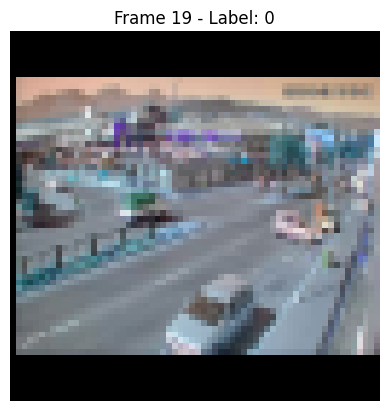

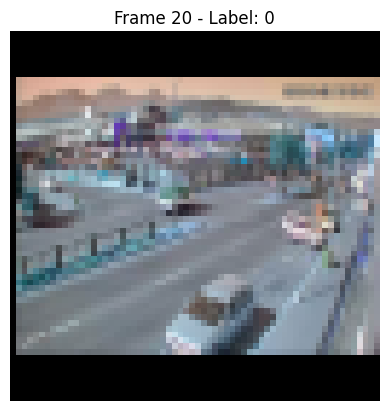

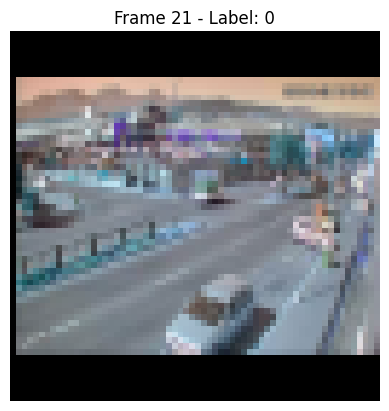

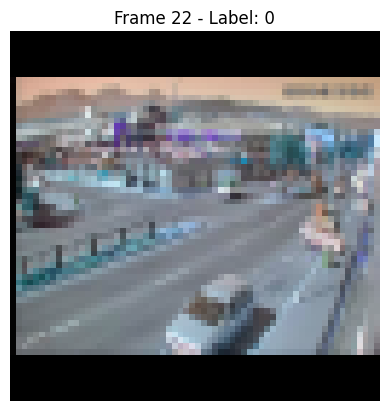

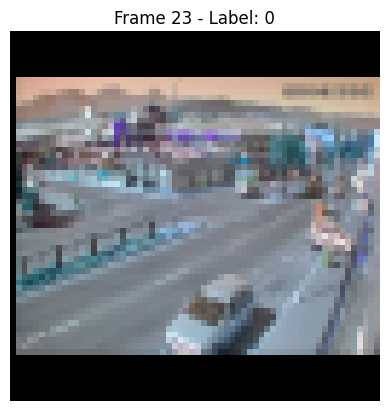

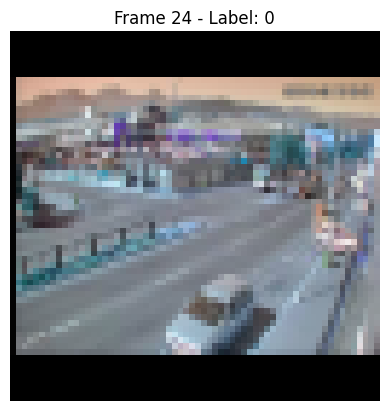

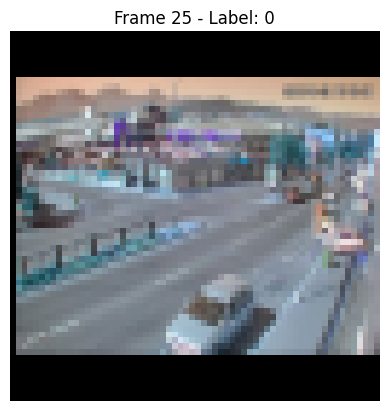

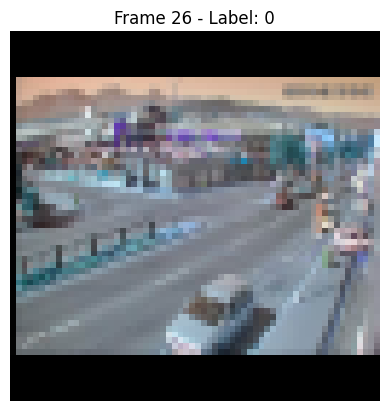

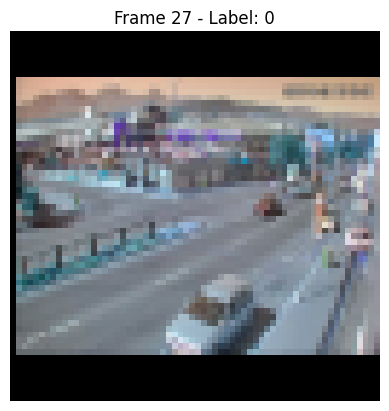

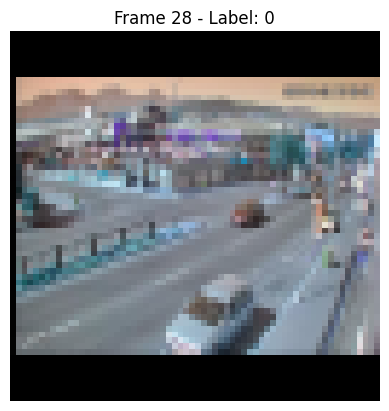

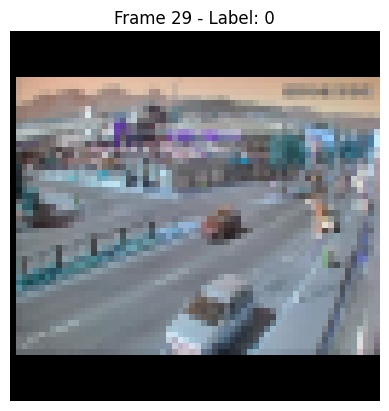

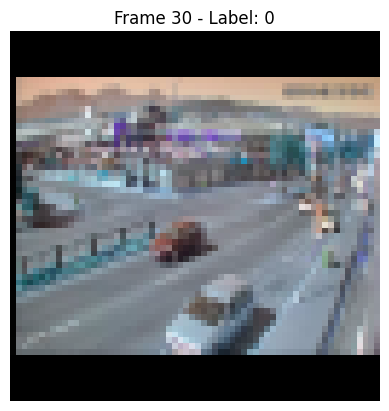

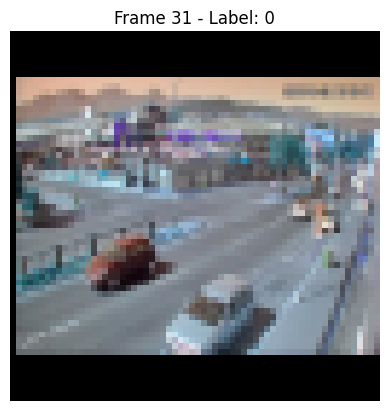

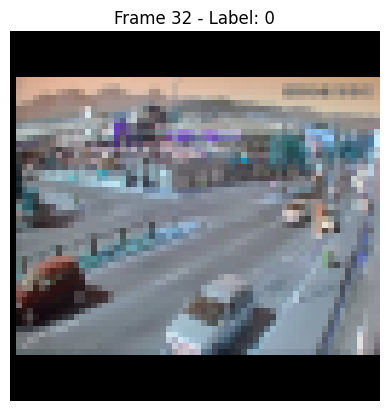

In [5]:
# Normal Video Example usage
npy_file_path = 'dataset/extracted_segments/testN/NormalVideos/video_6_segment_0.npy'
display_frames_from_npy(npy_file_path)

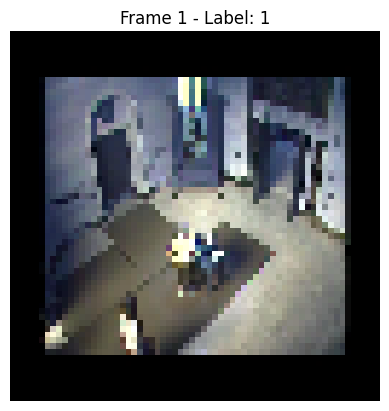

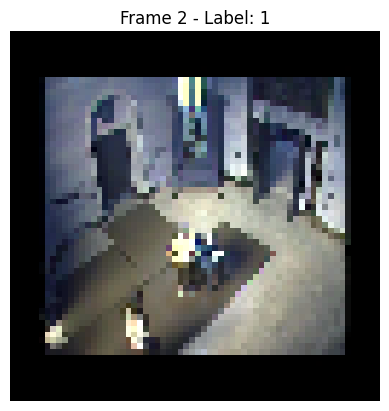

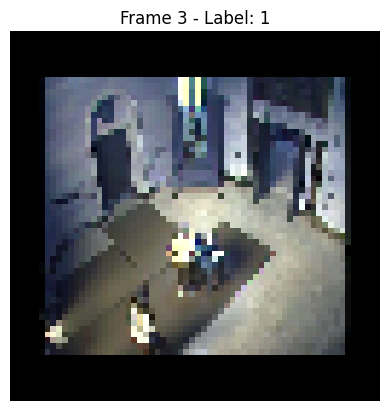

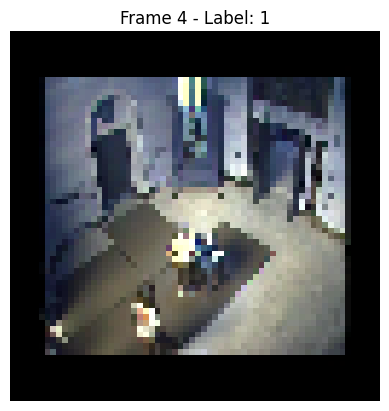

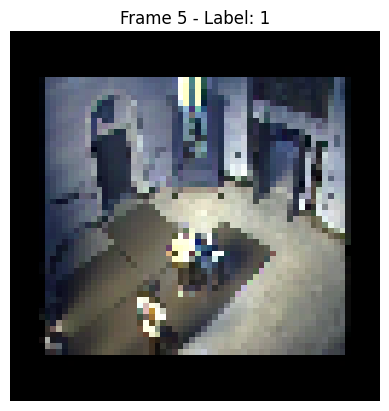

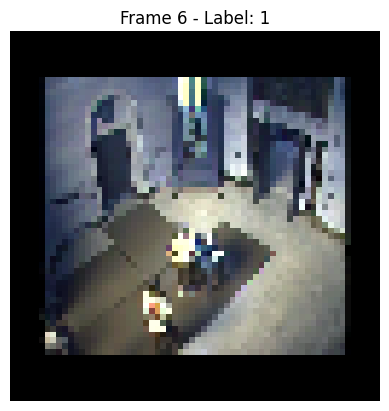

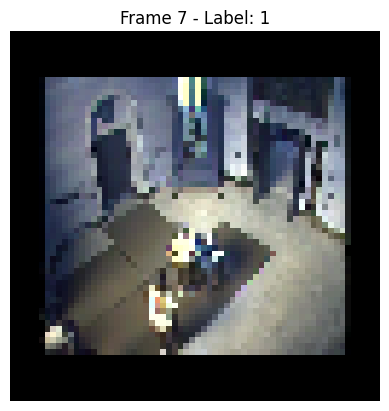

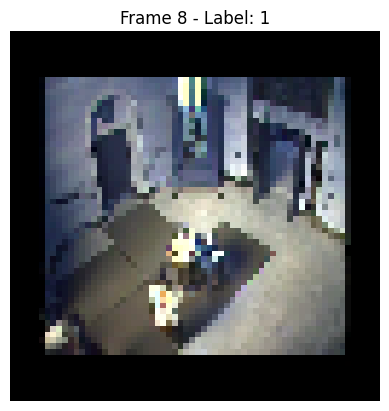

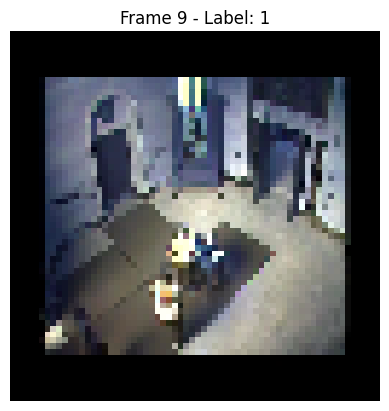

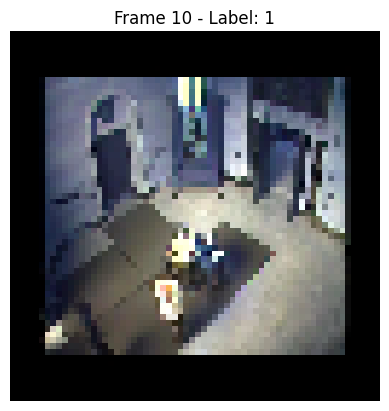

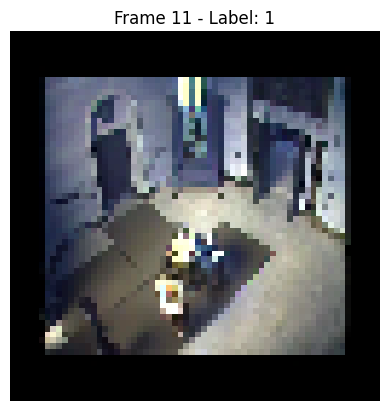

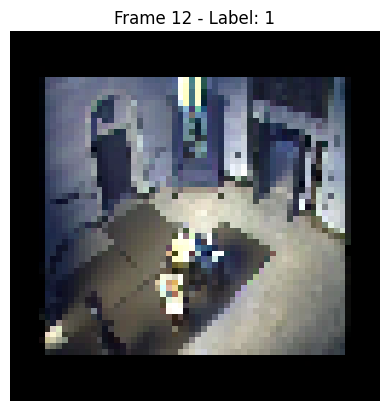

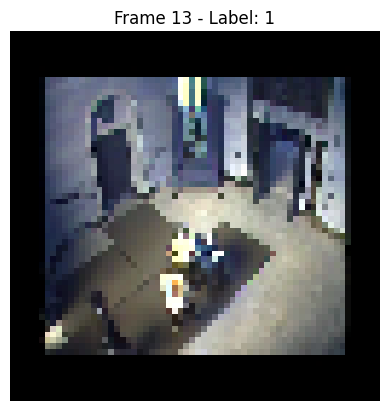

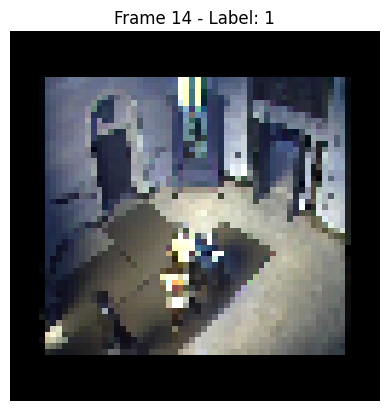

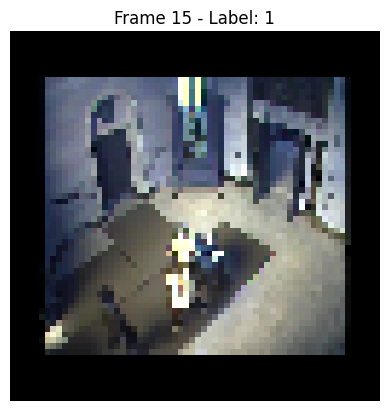

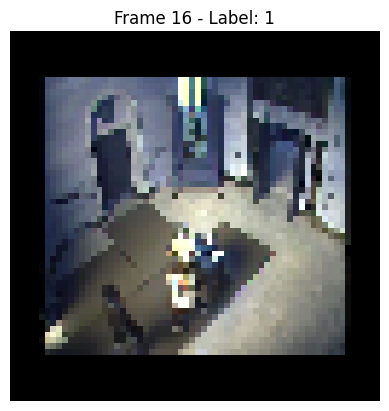

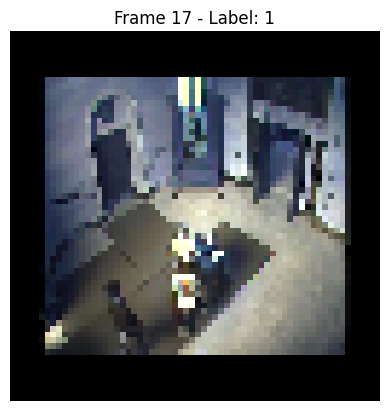

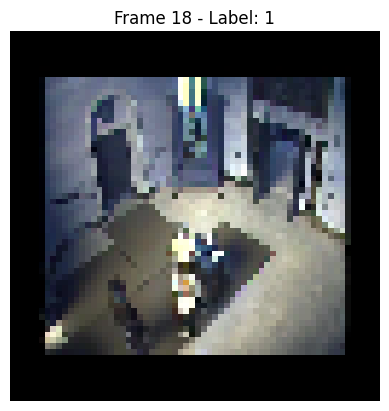

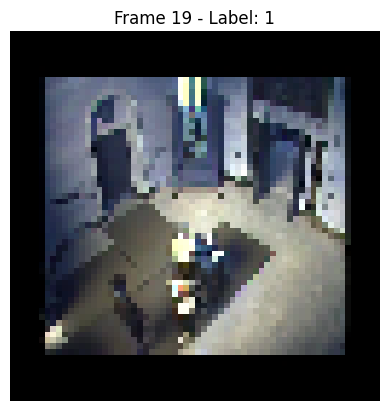

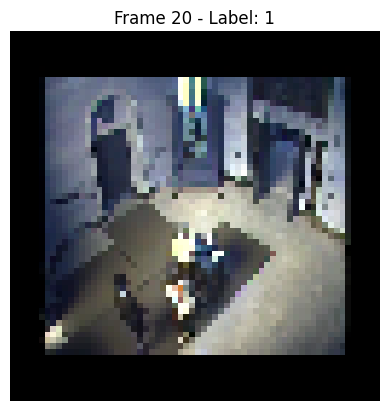

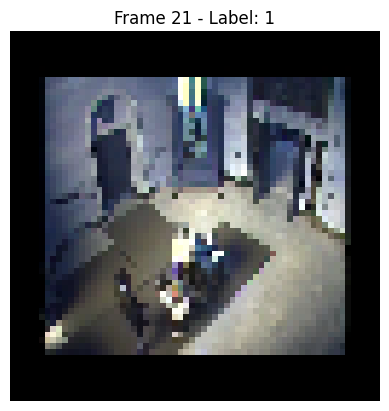

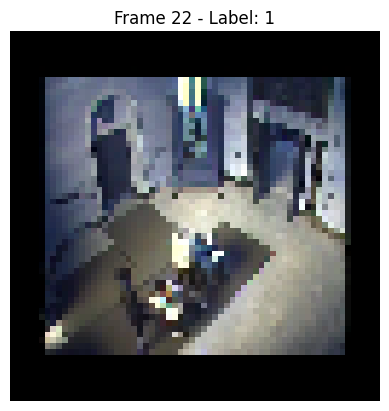

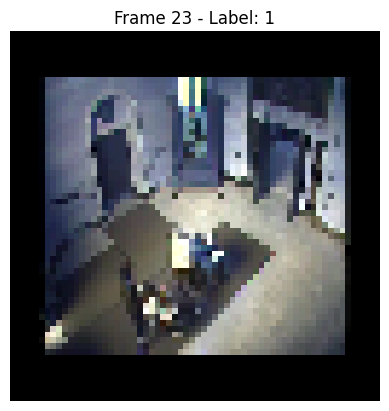

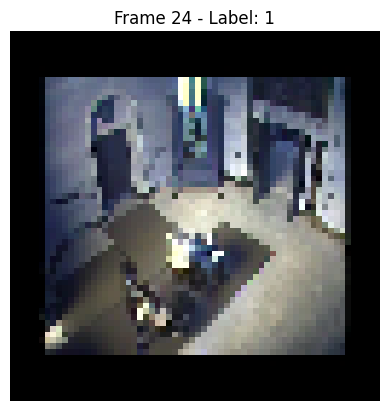

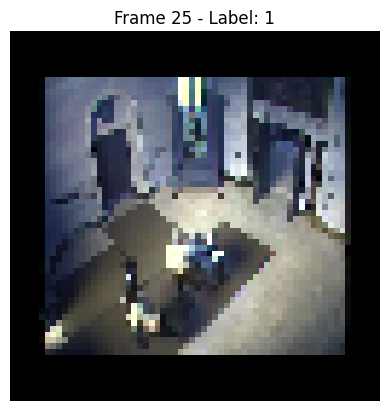

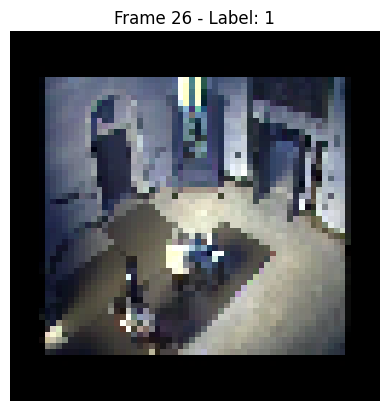

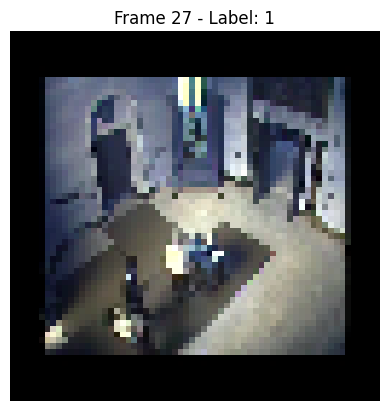

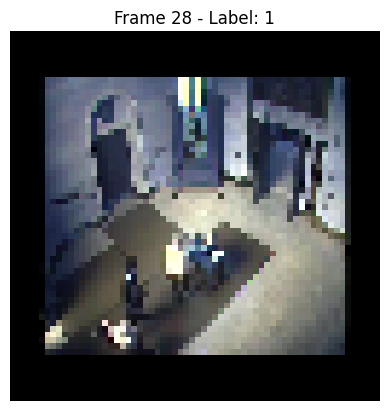

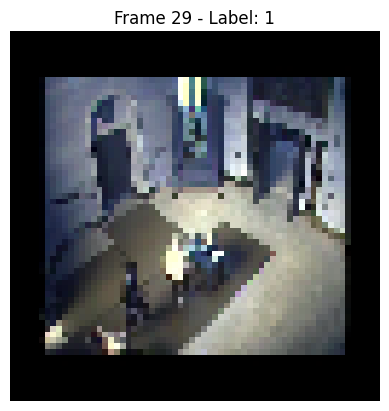

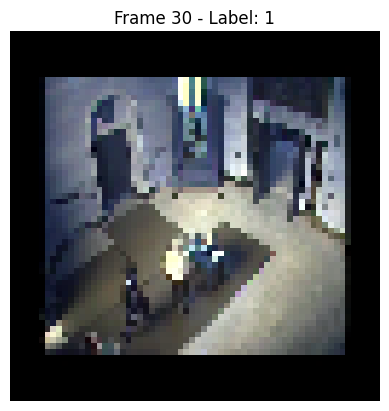

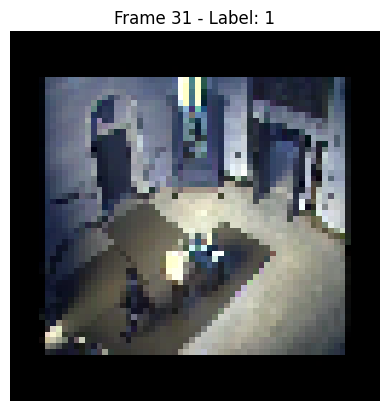

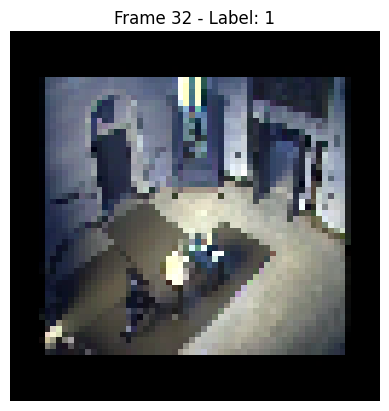

In [6]:
# Anamolus Video Example usage
npy_file_path = 'dataset/extracted_segments/train/Abuse_Abuse001_x264.mp4_segment_1.npy'
display_frames_from_npy(npy_file_path)